## Setup

In [3]:
# Setup - Run only once per Kernel App
%conda install openjdk -y

# install PySpark
%pip install pyspark==3.4.0

# install spark-nlp
%pip install spark-nlp==5.1.3

# restart kernel
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

Retrieving notices: ...working... done
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.3.1
  latest version: 23.11.0

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.11.0



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - openjdk


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2023.08.22 |       h06a4308_0         123 KB
    certifi-2023.11.17         |  py310h06a4308_0         158 KB
    openjdk-11.0.13            |       h87a67e3_0       341.0 MB
    ------------------------------------------------------------
                                           Total:       341.3 MB

The following NEW packages will be INSTALLED:

  openjdk            pkgs/main/

In [4]:
# Import pyspark and build Spark session
from pyspark.sql import SparkSession

spark = (
    SparkSession.builder.appName("PySparkApp")
    .config("spark.jars.packages", "org.apache.hadoop:hadoop-aws:3.2.2")
    .config(
        "fs.s3a.aws.credentials.provider",
        "com.amazonaws.auth.ContainerCredentialsProvider",
    )
    .getOrCreate()
)

print(spark.version)

:: loading settings :: url = jar:file:/opt/conda/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
org.apache.hadoop#hadoop-aws added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-18cf92e2-b313-439a-9f2a-7d9a3f5bf473;1.0
	confs: [default]
	found org.apache.hadoop#hadoop-aws;3.2.2 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.563 in central
:: resolution report :: resolve 480ms :: artifacts dl 36ms
	:: modules in use:
	com.amazonaws#aws-java-sdk-bundle;1.11.563 from central in [default]
	org.apache.hadoop#hadoop-aws;3.2.2 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   2   |   0   |   0   |   0   ||   2   |   0   |
	---------------------------------------------

3.4.0


## Read Data

In [5]:
%%time
import time
import sagemaker
from sagemaker.spark.processing import PySparkProcessor

session = sagemaker.Session()
bucket = session.default_bucket()
output_prefix_sub = "project/comments_sub"
s3_output_path = f"s3a://{bucket}/{output_prefix_sub}"

print(f"reading comments from {s3_output_path}")
comments = spark.read.parquet(s3_output_path, header=True)
print(f"shape of the comments dataframe is {comments.count():,}x{len(comments.columns)}")

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
reading comments from s3a://sagemaker-us-east-1-364814717103/project/comments_sub


23/12/07 16:03:19 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties


shape of the comments dataframe is 1,567,801x8
CPU times: user 2.96 s, sys: 406 ms, total: 3.37 s
Wall time: 34.1 s


In [8]:
%%time
session = sagemaker.Session()
bucket = session.default_bucket()
output_prefix_sub = "project/submissions_sub"
s3_output_path = f"s3a://{bucket}/{output_prefix_sub}"

print(f"reading submissions from {s3_output_path}")
submissions = spark.read.parquet(s3_output_path, header=True)
print(f"shape of the submissions dataframe is {submissions.count():,}x{len(submissions.columns)}")

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
reading submissions from s3a://sagemaker-us-east-1-364814717103/project/submissions_sub


shape of the submissions dataframe is 21,290x8
CPU times: user 132 ms, sys: 10 ms, total: 142 ms
Wall time: 8.23 s


## Data Cleaning

In [9]:
submissions = submissions.cache()
comments = comments.cache()

In [10]:
submissions = submissions.filter((submissions.selftext != "") & (submissions.selftext != "[deleted]")& (submissions.selftext != "[removed]"))

comments = comments.filter(comments.body != "")

In [11]:
from pyspark.sql.functions import col

submissions = submissions.select("subreddit", "author", "title", "selftext", "created_utc", "num_comments").filter(col("subreddit") == "CollegeBasketball")

comments = comments.select("subreddit", "author", "body", "parent_id", "created_utc").filter(col("subreddit") == "CollegeBasketball")

In [12]:
submissions.count()

9567

In [13]:
comments.count()

1567798

## Team Mentions of Submissions and Comments in `r/CollegeBasketball`

To commence our analysis of the 2022 basketball tournament, it's crucial to identify key teams for detailed study. Among the 68 participating teams, our focus will be on the **Elite 8**. These teams, namely Houston, Kansas, Villanova, Duke, Arkansas, Saint Peter's, North Carolina, and Miami, not only excelled in the tournament but also garnered significant audience interest, as per the 2022 DI Men's Basketball Championship Official Bracket (https://www.ncaa.com/brackets/basketball-men/d1/2022). Additionally, incorporating insights from `author_flair_text analysis`, we included Purdue and Illinois, two teams that enjoyed considerable support, to broaden our scope.\

To begin our examination of engagement levels in submissions and comments associated with each team, it's essential to develop a comprehensive keyword dictionary. This resource will facilitate precise analysis by identifying content related to the teams in focus. The dictionary will encompass various identifiers for each team, including official team names, popular nicknames, abbreviations, and other relevant terms. This approach ensures a thorough and accurate assessment of team-specific engagement.

In [14]:
# Define a dictionary of teams and associated keywords
team_keywords = {
    'houston': ['houston', 'cougars', 'uh', 'uh cougars'],
    'kansas': ['kansas', 'jayhawks', 'ku', 'rock chalk', 'ku jayhawks'],
    'villanova': ['villanova', 'wildcats', 'nova', 'villanova wildcats'],
    'duke': ['duke', 'blue devils', 'duke blue devils'],
    'arkansas': ['arkansas', 'razorbacks', 'hogs', 'u of a', 'arkansas razorbacks'],
    'saint peters': ["saint peter's", 'peacocks', "saint peter's peacocks", 'saint peters', "st. peter's", 'st peters', 'spu'],
    'north carolina': ['north carolina', 'tar heels', 'unc', 'unc tar heels'],
    'miami': ['miami', 'hurricanes', 'um', 'miami hurricanes'],
    'purdue': ['purdue', 'boilermakers', 'purdue boilermakers', 'pu'],
    'illinois': ['illinois', 'fighting illini', 'illini', 'u of i', 'university of illinois']
}

In [15]:
from pyspark.sql.functions import lower

# Lowercase the text fields for uniformity
comments = comments.withColumn('body', lower(col('body')))
submissions = submissions.withColumn('title', lower(col('title')))\
                         .withColumn('selftext', lower(col('selftext')))

In [16]:
from pyspark.sql.functions import udf, lit, array
from pyspark.sql.types import BooleanType

# Define the UDF to check the existence of key words
def keyword_present(text, keywords):
    if text:
        return any(keyword in text for keyword in keywords)
    return False

keyword_udf = udf(keyword_present, BooleanType())

In [17]:
# Apply the UDF
for team, keywords in team_keywords.items():
    submissions = submissions.withColumn(
        team,
        keyword_udf(col("title"), array([lit(k) for k in keywords])) | keyword_udf(col("selftext"), array([lit(k) for k in keywords]))
    )
    comments = comments.withColumn(
        team, 
        keyword_udf(col("body"), array([lit(k) for k in keywords]))
    )

In [18]:
# Check
submissions.printSchema

<bound method DataFrame.printSchema of DataFrame[subreddit: string, author: string, title: string, selftext: string, created_utc: timestamp, num_comments: bigint, houston: boolean, kansas: boolean, villanova: boolean, duke: boolean, arkansas: boolean, saint peters: boolean, north carolina: boolean, miami: boolean, purdue: boolean, illinois: boolean]>

In [19]:
from pyspark.sql.functions import sum as sql_sum

# Aggregate the counts for submissions
submissions_counts = submissions.select([sql_sum(col(team).cast("int")).alias(team) for team in team_keywords.keys()])

# Aggregate the counts for comments
comments_counts = comments.select([sql_sum(col(team).cast("int")).alias(team) for team in team_keywords.keys()])

In [20]:
print("Team Mentions in Submissions")
submissions_counts.show()

Team Mentions in Submissions


+-------+------+---------+----+--------+------------+--------------+-----+------+--------+
|houston|kansas|villanova|duke|arkansas|saint peters|north carolina|miami|purdue|illinois|
+-------+------+---------+----+--------+------------+--------------+-----+------+--------+
|    454|   969|      385| 453|     371|         149|           809| 3102|   840|     572|
+-------+------+---------+----+--------+------------+--------------+-----+------+--------+



In [21]:
print("Team Mentions in Comments")
comments_counts.show()

Team Mentions in Comments


+-------+------+---------+-----+--------+------------+--------------+-----+------+--------+
|houston|kansas|villanova| duke|arkansas|saint peters|north carolina|miami|purdue|illinois|
+-------+------+---------+-----+--------+------------+--------------+-----+------+--------+
|  17144| 34285|    12317|31856|    9246|        6020|         46033|69595| 70959|   14189|
+-------+------+---------+-----+--------+------------+--------------+-----+------+--------+



In [23]:
# Convert the Spark DataFrame to a Pandas DataFrame
submissions_counts_pd = submissions_counts.toPandas()
comments_counts_pd = comments_counts.toPandas()

In [28]:
# Transform the DataFrame to a long format
submissions_counts_long = submissions_counts_pd.melt(var_name='Teams', value_name='Mentions')
comments_counts_long = comments_counts_pd.melt(var_name='Teams', value_name='Mentions')

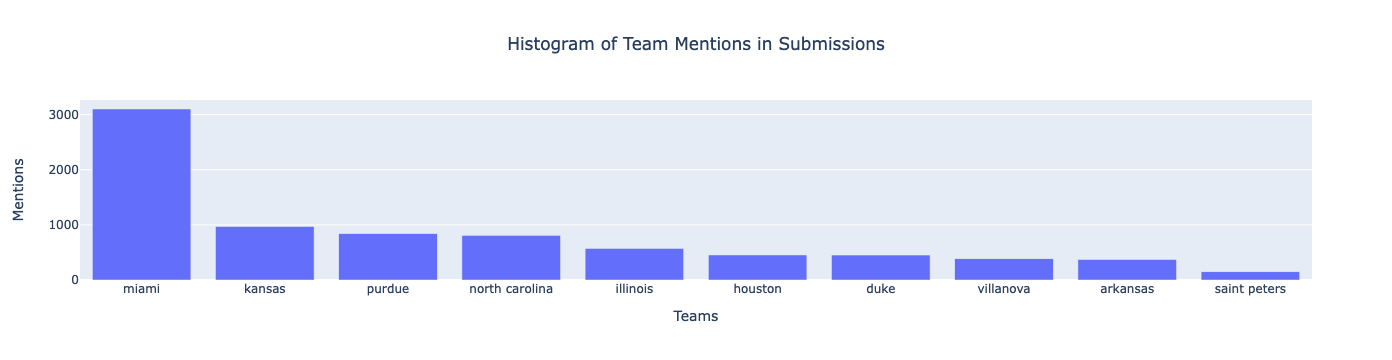

In [30]:
import plotly.express as px

# Create the interactive Histogram for Submissions Counts
fig1 = px.bar(submissions_counts_long, x='Teams', y='Mentions', title='Histogram of Team Mentions in Submissions')

fig1.update_layout(
    xaxis_title='Teams',
    yaxis_title='Mentions',
    xaxis={'categoryorder':'total descending'},
    title_x=0.5
)

fig1.show()

The graph presents a striking observation: Miami is mentioned markedly more often than other teams, a notably unexpected finding. Additionally, it reveals that the comment mention counts for Kansas, the 2022 champion, North Carolina, the runner-up, and the consistently strong Purdue, significantly exceed those of other teams. This aligns with typical expectations and highlights their prominence in discussions.

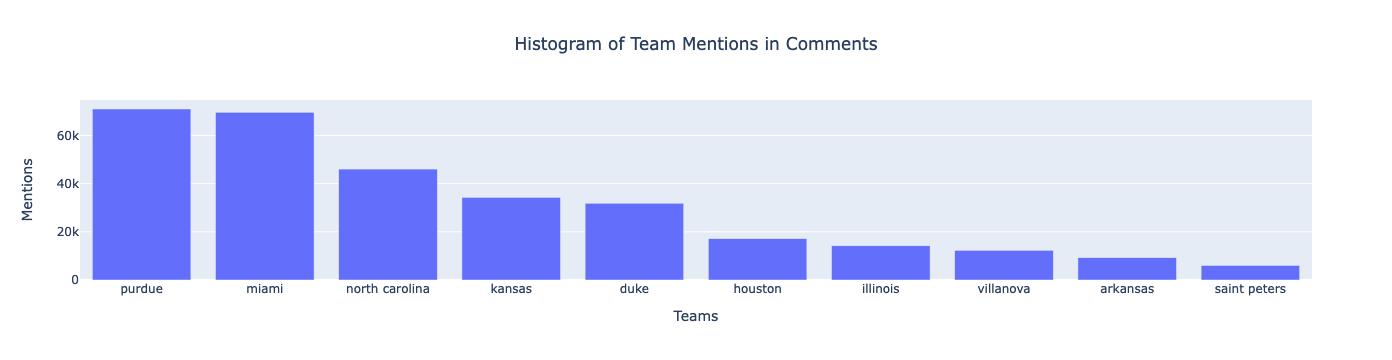

In [29]:
# Create the interactive Histogram for Comments Counts
fig2 = px.bar(comments_counts_long, x='Teams', y='Mentions', title='Histogram of Team Mentions in Comments')

fig2.update_layout(
    xaxis_title='Teams',
    yaxis_title='Mentions',
    xaxis={'categoryorder':'total descending'},
    title_x=0.5
)

fig2.show()

The data from the comment counts largely mirrors the trends observed in the previous figure, with a notable exception: Purdue's mentions significantly surpass those of Kansas and North Carolina, aligning them more closely with Miami's high mention frequency. This suggests a distinct level of engagement and interest in Purdue, setting it apart from the other teams.\
The empirical analysis reveals a correlation between a team's number of mentions and factors like popularity and season performance. Frequently mentioned teams include top performers like Kansas, the eventual champions, and unexpected contenders like North Carolina, which aligns with our initial expectations. Intriguingly, a team like Miami, despite a lower seed ranking and only reaching the top eight, has garnered more submissions and comment mentions than even the championship team. This anomaly suggests there are additional underlying factors influencing Miami's high visibility, warranting further investigation to uncover these reasons.

## Daily Team Mentions of Submissions and Comments in `r/CollegeBasketball`

As we progress, our objective is to conduct a detailed analysis of the daily mention trends for each team. This will offer a more nuanced understanding of how audience engagement evolved over the course of the tournament. To optimize our analysis, and informed by our previous findings, we've narrowed our focus to Miami, Kansas, North Carolina, and Purdue. These four teams, having attracted a significantly higher volume of mentions, are ideal candidates for our in-depth examination of engagement patterns.

In [31]:
from pyspark.sql.functions import dayofmonth, month, year

# Aggregate the daily mention counts for each team
daily_mentions_comments = comments.groupBy(
    year("created_utc").alias("year"),
    month("created_utc").alias("month"),
    dayofmonth("created_utc").alias("day")
).agg(
    sql_sum(col('kansas').cast('int')).alias('kansas'),
    sql_sum(col('purdue').cast('int')).alias('purdue'),
    sql_sum(col('north carolina').cast('int')).alias('north_carolina'),
    sql_sum(col('miami').cast('int')).alias('miami'),
    sql_sum(col('duke').cast('int')).alias('duke'),
    sql_sum(col('houston').cast('int')).alias('houston'),
    sql_sum(col('illinois').cast('int')).alias('illinois'),
    sql_sum(col('villanova').cast('int')).alias('villanova'),
    sql_sum(col('arkansas').cast('int')).alias('arkansas'),
    sql_sum(col('saint peters').cast('int')).alias('saint_peters')
)

daily_mentions_submissions = submissions.groupBy(
    year("created_utc").alias("year"),
    month("created_utc").alias("month"),
    dayofmonth("created_utc").alias("day")
).agg(
    sql_sum(col('kansas').cast('int')).alias('kansas'),
    sql_sum(col('purdue').cast('int')).alias('purdue'),
    sql_sum(col('north carolina').cast('int')).alias('north_carolina'),
    sql_sum(col('miami').cast('int')).alias('miami'),
    sql_sum(col('duke').cast('int')).alias('duke'),
    sql_sum(col('houston').cast('int')).alias('houston'),
    sql_sum(col('illinois').cast('int')).alias('illinois'),
    sql_sum(col('villanova').cast('int')).alias('villanova'),
    sql_sum(col('arkansas').cast('int')).alias('arkansas'),
    sql_sum(col('saint peters').cast('int')).alias('saint_peters')
)

In [34]:
import pandas as pd

# Convert the Spark DataFrame to a Pandas DataFrame
daily_mentions_submissions_pd = daily_mentions_submissions.toPandas()
daily_mentions_comments_pd = daily_mentions_comments.toPandas()

# Convert year, month, day to a datetime object
daily_mentions_submissions_pd['date'] = pd.to_datetime(daily_mentions_submissions_pd[['year', 'month', 'day']])
daily_mentions_comments_pd['date'] = pd.to_datetime(daily_mentions_comments_pd[['year', 'month', 'day']])

# Set the 'date' column as index
daily_mentions_submissions_pd.set_index('date', inplace=True)
daily_mentions_comments_pd.set_index('date', inplace=True)

# Drop the year, month, and day columns
daily_mentions_submissions_pd.drop(['year', 'month', 'day'], axis=1, inplace=True)
daily_mentions_comments_pd.drop(['year', 'month', 'day'], axis=1, inplace=True)

# Sort the DataFrame by date
daily_mentions_submissions_pd.sort_index(inplace=True)
daily_mentions_comments_pd.sort_index(inplace=True)

In [35]:
# Melt the DataFrame to long format for Plotly
daily_mentions_submissions_long = daily_mentions_submissions_pd.reset_index().melt(id_vars=['date'], 
                                                                                  var_name='Team', 
                                                                                  value_name='Mentions')
daily_mentions_comments_long = daily_mentions_comments_pd.reset_index().melt(id_vars=['date'], 
                                                                                  var_name='Team', 
                                                                                  value_name='Mentions')

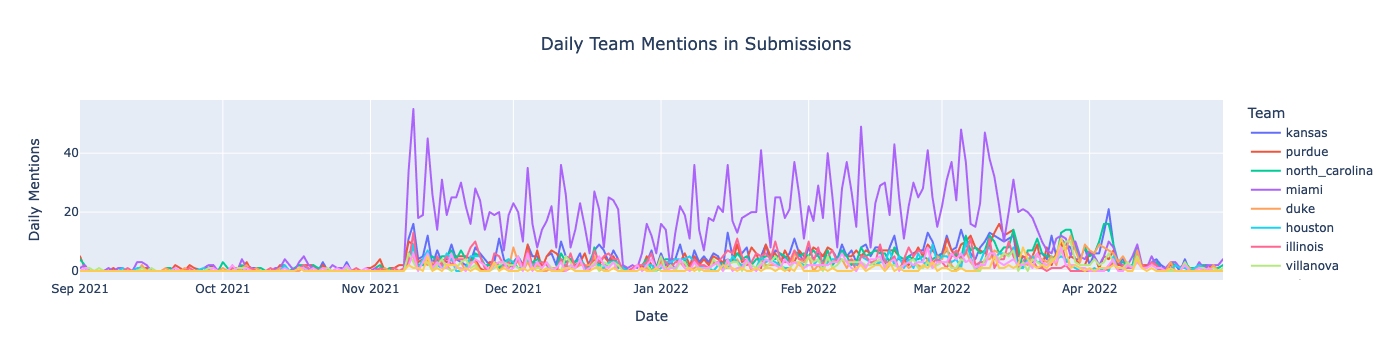

In [36]:
# Create the interactive line plot
fig3 = px.line(daily_mentions_submissions_long, 
              x='date', 
              y='Mentions', 
              color='Team', 
              title='Daily Team Mentions in Submissions')

fig3.update_layout(
    xaxis_title='Date',
    yaxis_title='Daily Mentions',
    title_x=0.5,
    legend_title_text='Team'
)

fig3.show()

The temporal distribution of team mentions in the dataset displays marked variability, suggesting a correlation with fluctuating levels of public interest, possibly driven by match schedules, pivotal games, or noteworthy events. Certain teams experience pronounced spikes in mentions, which could be indicative of key matches or pivotal moments in the season that galvanized public attention.\
The frequency of mentions potentially mirrors team popularity or their competitive performance, with consistently mentioned teams likely enjoying robust support or delivering compelling performances. For instance, from the commencement of the season in November 2021 through to March 2022, mentions of Miami dominated the discourse, outstripping other teams in visibility. This trend, however, experienced a reversal in mid-March 2022, with Miami’s mention frequency tapering to levels comparable with its peers, an anomaly that warrants further inquiry to elucidate the underlying factors.\
In parallel, the discourse surrounding Kansas and North Carolina witnessed a pronounced uptick, reaching an apex in early April 2022. This surge can be directly attributed to their advancement to the finals, mirroring the crescendo of public engagement and interest as these teams progressed through critical stages of the tournament.\
The mention trajectory for the remaining teams adheres to a somewhat predictable pattern: a sharp escalation post the season’s inception in November, followed by a series of oscillations in sync with the unfolding of the games, and typically culminating in a zenith coinciding with their final matches before a swift decline.

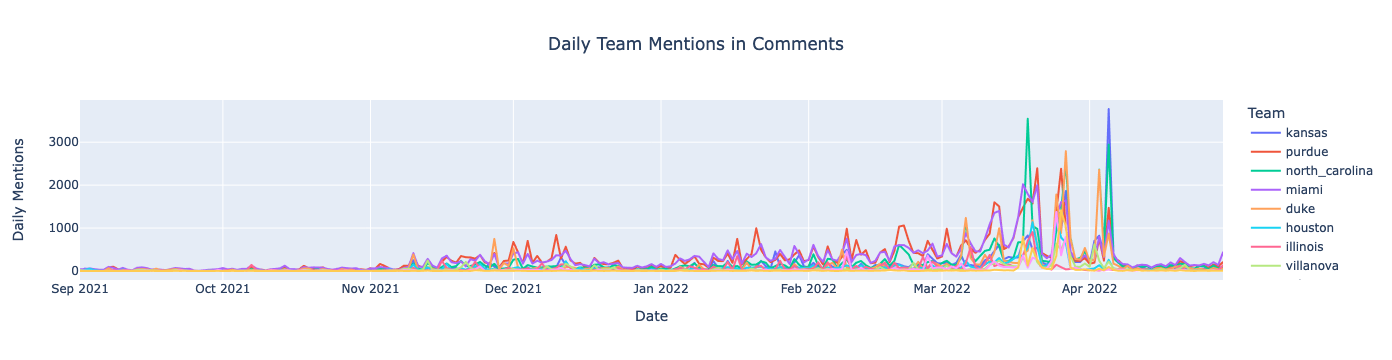

In [38]:
fig4 = px.line(daily_mentions_comments_long, 
              x='date', 
              y='Mentions', 
              color='Team', 
              title='Daily Team Mentions in Comments')

fig4.update_layout(
    xaxis_title='Date',
    yaxis_title='Daily Mentions',
    title_x=0.5,
    legend_title_text='Team'
)

fig4.show()

Echoing the trends observed in the Submissions, the Comments plot reveals even more stark fluctuations in daily mentions. These pronounced spikes in activity are indicative of significant rallying points in public discourse, potentially tethered to pivotal games or momentous events that captivated the audience's attention.\
In a comparative lens, the Comments plot registers a more voluminous mention count than its Submissions counterpart, suggesting a propensity for the community to engage more actively through commentary rather than through initiating new Submissions. This could reflect a community behavioral pattern where commenting serves as a more immediate and communal form of interaction in the discourse surrounding team performances.\
The data shows that while Miami and Purdue have a higher volume of daily comments, the disparity isn’t as marked when compared to other teams. Both teams experienced a peak in comment activity from mid-to-late March. This trend aligns with key tournament events: Purdue’s journey ended in the top 16 after their loss to St. Peter’s on March 25, while Miami concluded in the top 8 following their defeat by Kansas on March 27. North Carolina’s peak in comment volume around mid-March can be directly attributed to their victory over the previous year’s champions, Baylor. Kansas distinguished itself with a comment volume zenith in early April 2022, eclipsing all other teams. This surge is emblematic of their ascension to the championship, sparking a wave of audience interaction and discussion reflective of their ultimate victory.\
Overall, the variations in comment volume mirror the dynamics of audience engagement. As the season approaches its climax, particularly the finals, discussions intensify. The disparity in comment counts across different teams highlights the variations in their popularity and performance throughout the season. The data vividly illustrates that audience engagement peaked during critical matches, with this fervor culminating in the finals on April 4, indicating a high level of interest and involvement from fans during these pivotal moments of the tournament.